I chose data coming from credit card applications and records. The data is downloaded from Kaggle and can be found at https://www.kaggle.com/rikdifos/credit-card-approval-prediction

I will follow the IBM Garage Method for Data Science approach to solve the suggested task of <font color="red">building a model to predict if an applicant is 'good' or 'bad' client, the definition of 'good' or 'bad' is not given</font>. The model will be developed in a local Jupyter Notebook for simplicity and later transferred to an IBM Data Platform notebook to train it and serialize it. Finally, I will deploy the model in the Google Cloud ML managed service.  

# <font color="purple">Download files</font>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

![ -f ./credit-card-approval-prediction.zip ] || kaggle datasets download rikdifos/credit-card-approval-prediction

!unzip -o credit-card-approval-prediction.zip -d .

kaggle.json
/bin/bash: kaggle: command not found
unzip:  cannot find or open credit-card-approval-prediction.zip, credit-card-approval-prediction.zip.zip or credit-card-approval-prediction.zip.ZIP.


# <font color="purple">General Dependencies</font>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
import statsmodels.formula.api as smf
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings('ignore')

# <font color="purple">EDA</font>

## Load CSV files

In [3]:
df_record = pd.read_csv("credit_record.csv")
df_application = pd.read_csv("application_record.csv")

In [4]:
df_record.head(10)

ID  MONTHS_BALANCE STATUS
0  5001711               0      X
1  5001711              -1      0
2  5001711              -2      0
3  5001711              -3      0
4  5001712               0      C
5  5001712              -1      C
6  5001712              -2      C
7  5001712              -3      C
8  5001712              -4      C
9  5001712              -5      C

In [5]:
df_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


### Month balance
The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
### Status
0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month

<font color="red">I will assume that any overdue of 60 or more days corresponds to a default</font>

In [6]:
df_application.head(10)

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   
5  5008810           F            N               Y             0   
6  5008811           F            N               Y             0   
7  5008812           F            N               Y             0   
8  5008813           F            N               Y             0   
9  5008814           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   
5          270000.0  Commercial associate  Secondary / secondary special   
6          270000.0  Commercial associate  Secondary / secondary special   
7          283500.0             Pensioner               Higher education   
8          283500.0             Pensioner               Higher education   
9          283500.0             Pensioner               Higher education   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005          -4542   
1        Civil marriage   Rented apartment      -12005          -4542   
2               Married  House / apartment      -21474          -1134   
3  Single / not married  House / apartment      -19110          -3051   
4  Single / not married  House / apartment      -19110          -3051   
5  Single / not married  House / apartment      -19110          -3051   
6  Single / not married  House / apartment      -19110          -3051   
7             Separated  House / apartment      -22464         365243   
8             Separated  House / apartment      -22464         365243   
9             Separated  House / apartment      -22464         365243   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                1           0           0             NaN   
1           1                1           0           0             NaN   
2           1                0           0           0  Security staff   
3           1                0           1           1     Sales staff   
4           1                0           1           1     Sales staff   
5           1                0           1           1     Sales staff   
6           1                0           1           1     Sales staff   
7           1                0           0           0             NaN   
8           1                0           0           0             NaN   
9           1                0           0           0             NaN   

   CNT_FAM_MEMBERS  
0              2.0  
1              2.0  
2              2.0  
3              1.0  
4              1.0  
5              1.0  
6              1.0  
7              1.0  
8              1.0  
9              1.0

In [7]:
df_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [8]:
number_unique_clients_in_records = df_record["ID"].nunique()

In [9]:
number_unique_clients_in_applications = df_application["ID"].nunique()

In [10]:
print(f"""{round(len(df_record.query('STATUS in ["2","3","4","5"]').groupby("ID"))/number_unique_clients_in_records*100,2)}% of clients with records defaulted at least once""")

1.45% of clients with records defaulted at least once


## Overview

In [11]:
ProfileReport(df_record, title="Records report", explorative=False)

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
ProfileReport(df_application, title="Applications report")

Summarize dataset:   0%|          | 0/31 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

There are significant missing values only in the OCCUPATION_TYPE field and some ID duplicates in the application registers. Also, the FLAG_MOBIL feature is always 1 so it can be dropped since it doesn't add valuable information

## Categorical features unique values

In [13]:
for column in df_application.columns:
    if df_application[column].dtype == "object":
        print(column)
        print(df_application[column].unique())

CODE_GENDER
['M' 'F']
FLAG_OWN_CAR
['Y' 'N']
FLAG_OWN_REALTY
['Y' 'N']
NAME_INCOME_TYPE
['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']
NAME_EDUCATION_TYPE
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS
['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']
NAME_HOUSING_TYPE
['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']
OCCUPATION_TYPE
[nan 'Security staff' 'Sales staff' 'Accountants' 'Laborers' 'Managers'
 'Drivers' 'Core staff' 'High skill tech staff' 'Cleaning staff'
 'Private service staff' 'Cooking staff' 'Low-skill Laborers'
 'Medicine staff' 'Secretaries' 'Waiters/barmen staff' 'HR staff'
 'Realty agents' 'IT staff']


## Duplicates

In [14]:
id_counts = df_application.groupby("ID")["ID"].count()
duplicate_ids_list = id_counts[id_counts > 1].index

In [15]:
df_application_duplicates = df_application[df_application["ID"].isin(duplicate_ids_list)].sort_values("ID")
df_application_duplicates.head(20)

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
426818  7022197           M            Y               Y             3   
425023  7022197           F            N               Y             0   
431545  7022327           F            N               Y             0   
431911  7022327           M            Y               Y             0   
425486  7023108           M            Y               Y             1   
426488  7023108           F            N               N             0   
425306  7023651           F            N               N             0   
421907  7023651           M            Y               N             1   
427778  7024111           M            N               N             2   
432643  7024111           F            N               Y             0   
424708  7036518           F            N               Y             0   
429078  7036518           F            N               N             1   
427007  7045794           F            N               N             0   
428048  7045794           F            N               Y             2   
432271  7045885           F            N               N             2   
426022  7045885           M            N               Y             0   
432134  7046068           F            N               Y             0   
424618  7046068           F            N               Y             0   
428171  7050948           F            N               N             0   
430746  7050948           F            N               Y             1   

        AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
426818          135000.0               Working  Secondary / secondary special   
425023          450000.0  Commercial associate               Higher education   
431545          135000.0  Commercial associate  Secondary / secondary special   
431911          256500.0  Commercial associate               Higher education   
425486           67500.0               Working  Secondary / secondary special   
426488          135000.0               Working  Secondary / secondary special   
425306          225000.0  Commercial associate              Incomplete higher   
421907          157500.0  Commercial associate              Incomplete higher   
427778          157500.0  Commercial associate  Secondary / secondary special   
432643          180000.0               Working  Secondary / secondary special   
424708          360000.0               Working               Higher education   
429078          180000.0               Working  Secondary / secondary special   
427007          414000.0               Working               Higher education   
428048          225000.0               Working  Secondary / secondary special   
432271          247500.0  Commercial associate  Secondary / secondary special   
426022           67500.0             Pensioner  Secondary / secondary special   
432134          112500.0               Working  Secondary / secondary special   
424618          135000.0             Pensioner  Secondary / secondary special   
428171          135000.0  Commercial associate               Higher education   
430746           81000.0               Working               Higher education   

          NAME_FAMILY_STATUS    NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
426818               Married    House / apartment      -11945           -735   
425023             Separated    House / apartment      -19813          -1799   
431545  Single / not married    House / apartment      -14771          -5298   
431911               Married    House / apartment      -21503          -1674   
425486               Married    House / apartment      -15156          -1696   
426488               Married    House / apartment      -17590          -1273   
425306  Single / not married    House / apartment      -10229          -1209   
421907               Married    House / apartment      -10521          -1457   
427778        Civil marriage    Hous

It is interesting to see that the ID duplicates have contrastant information in the application registers, like being female and male, or married and single for the same ID.

In [16]:
df_application_duplicates.merge(df_record,how="inner",on="ID")

Empty DataFrame
Columns: [ID, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, DAYS_BIRTH, DAYS_EMPLOYED, FLAG_MOBIL, FLAG_WORK_PHONE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, MONTHS_BALANCE, STATUS]
Index: []

However, non of the application ID duplicates are present in the records

## Missing values

<AxesSubplot:>

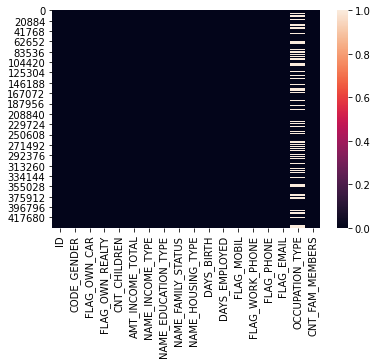

In [17]:
sns.heatmap(df_application.isnull())

There are nearly 30% missing values for the OCCUPATION_TYPE field in the applications dataset

<AxesSubplot:>

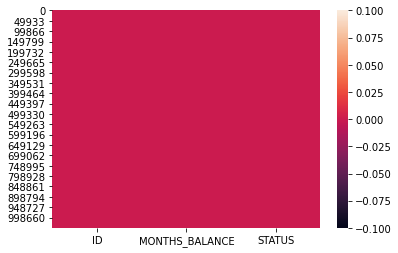

In [18]:
sns.heatmap(df_record.isnull())

There are no missing values in the records dataset

## Distributions

In [19]:
df_application.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],
      dtype='object')

CNT_CHILDREN


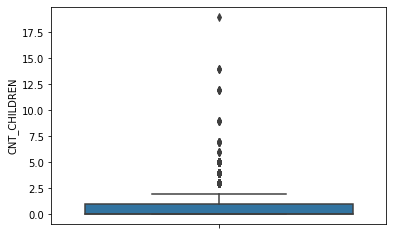

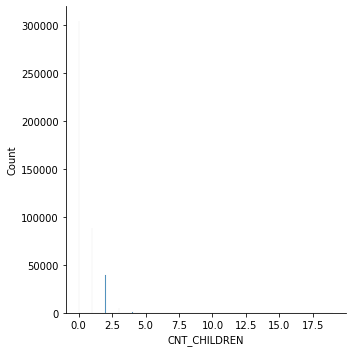

AMT_INCOME_TOTAL


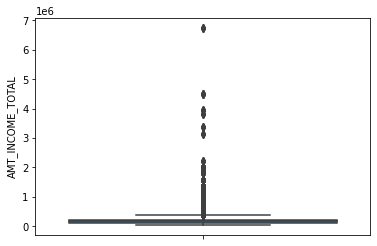

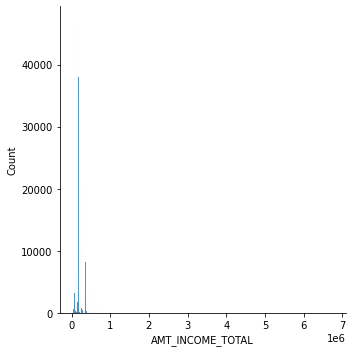

DAYS_BIRTH


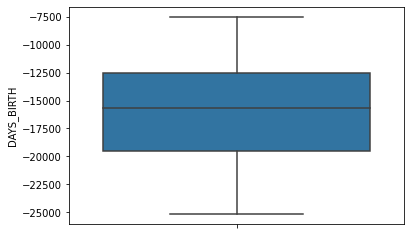

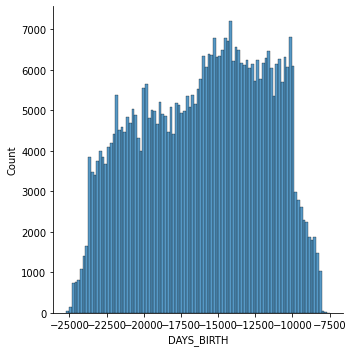

DAYS_EMPLOYED


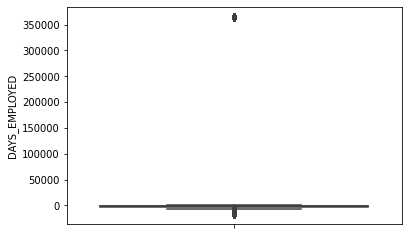

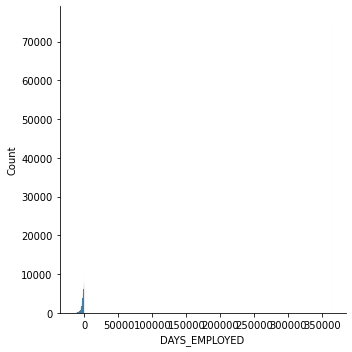

FLAG_MOBIL


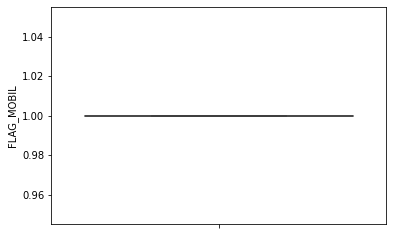

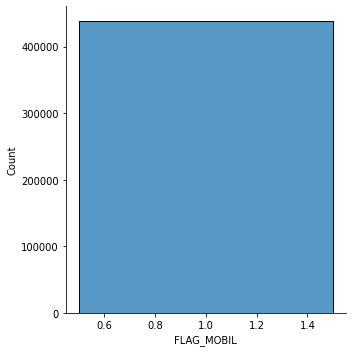

FLAG_WORK_PHONE


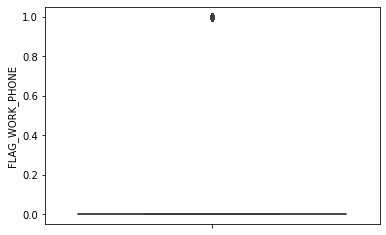

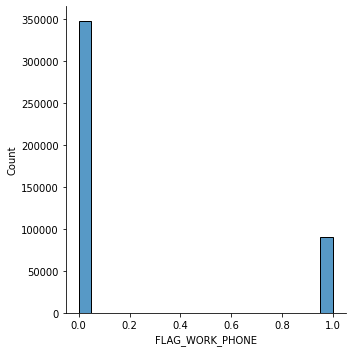

FLAG_PHONE


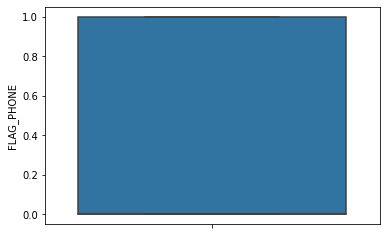

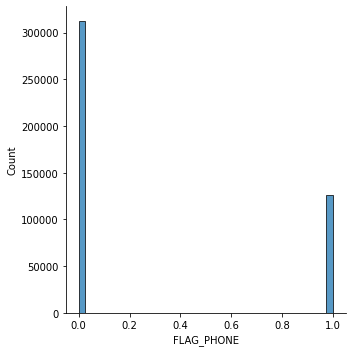

FLAG_EMAIL


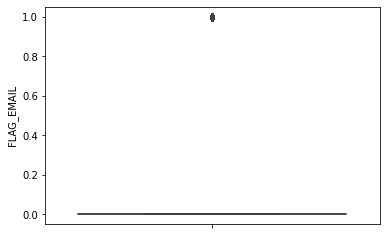

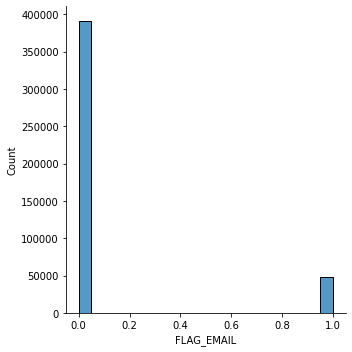

CNT_FAM_MEMBERS


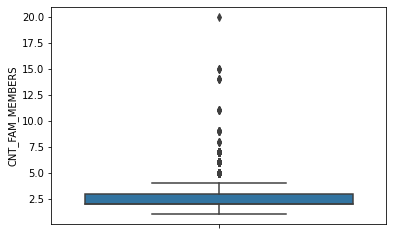

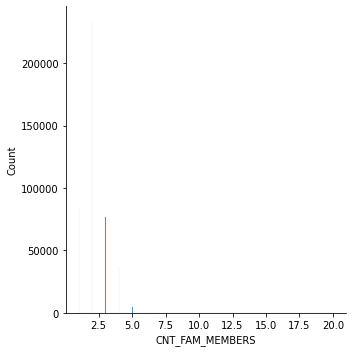

In [20]:
# Plot disctribution graphs for all numerical features
for feature in df_application.columns:
    if df_application[feature].dtype != "object" and feature != "ID":
        print(feature)
        sns.boxplot(data=df_application,y=feature)
        plt.show()
        sns.displot(data=df_application,x=feature)
        plt.show()

## Complementary EDA

Plot the heatmap of the months elapsed for defaulting

<AxesSubplot:xlabel='MONTHS_BALANCE', ylabel='STATUS'>

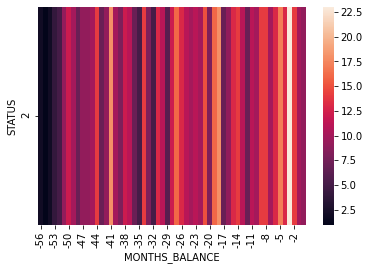

In [21]:
# Find the first overdue record for each customer and its corresponding month
df_defaults = df_record.query("STATUS in ['2']")
df_first_defaults = df_defaults.loc[df_defaults.groupby("ID")["MONTHS_BALANCE"].idxmin().values]
sns.heatmap(pd.crosstab(df_first_defaults["STATUS"],df_first_defaults["MONTHS_BALANCE"]))

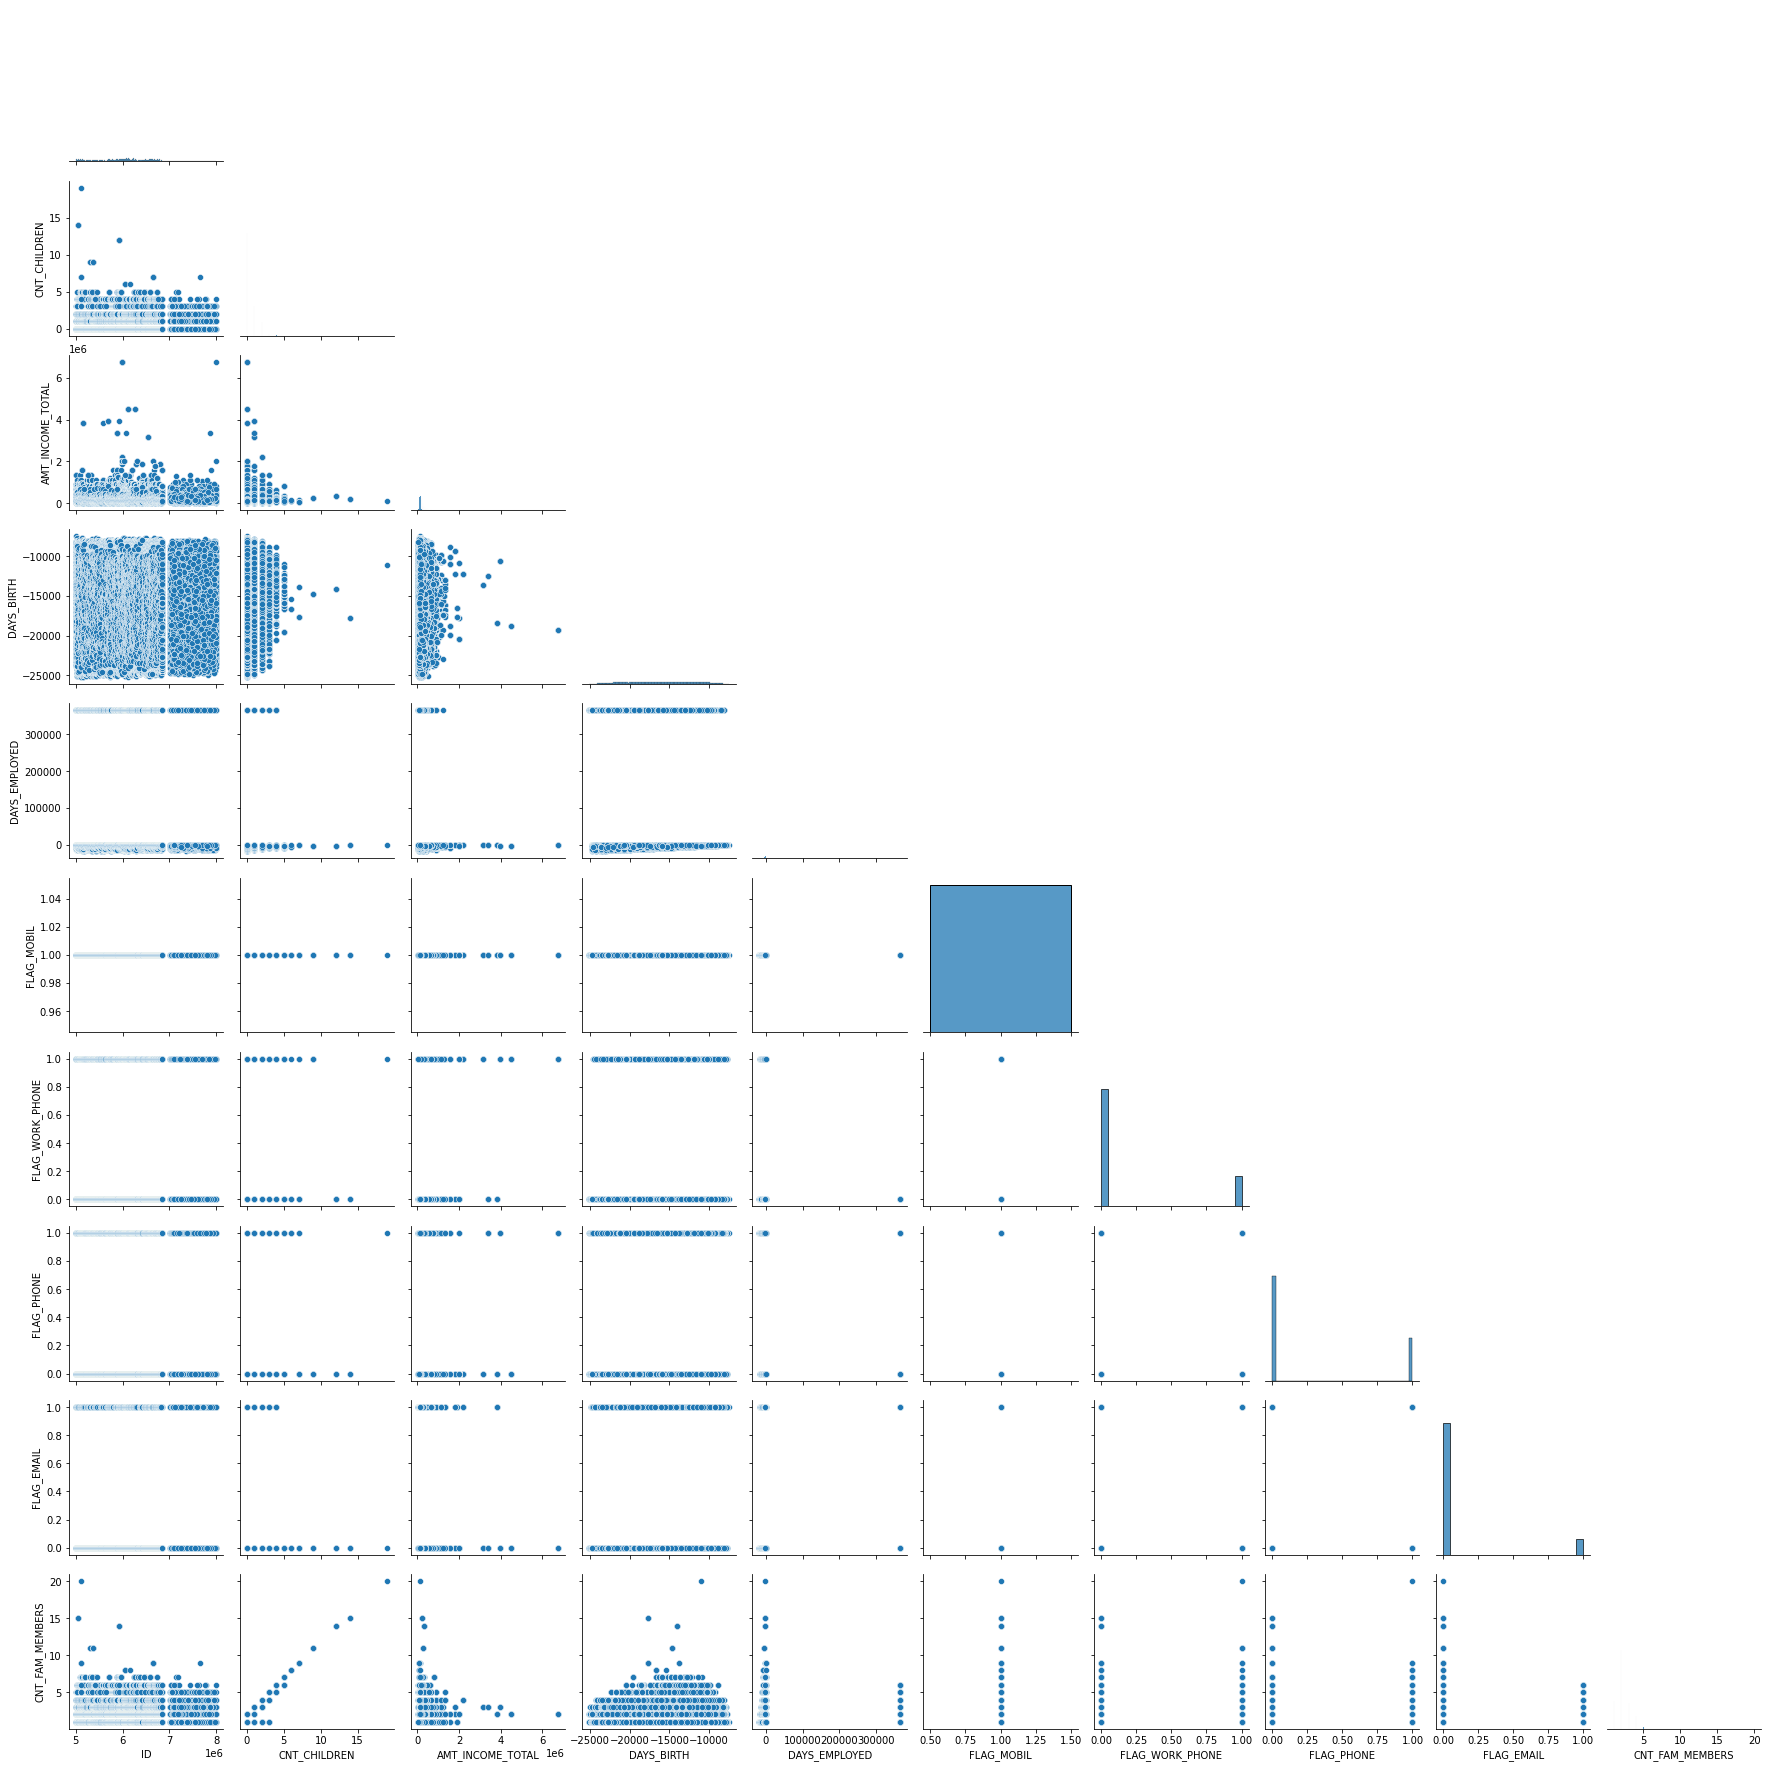

In [22]:
sns.pairplot(df_application,diag_kind="hist",corner=True)

The pairplot visualization helps us to understand the relations between the variables and their own distributions. The correlations are weak and most of the variables have a low cardinality. 

# <font color="purple">Feature Engineering</font>

Remove FLAG_MOBIL since it is a constant and OCCUPATION_TYPE because it has too many missing values

In [23]:
df_application.drop(columns=["FLAG_MOBIL","OCCUPATION_TYPE"],inplace=True)

Remove duplicate ids for having unreliable information. However, there is no duplicate application ID that has credit records so this shouldn't affect the results

In [24]:
df_application = df_application[~df_application["ID"].isin(duplicate_ids_list)]

Create DEFAULT (target) feature

In [25]:
# 0 for overdue records and 1 for the rest
df_record["DEFAULT"] = df_record["STATUS"].apply(lambda x: 0 if x in ["X","C","0","1"] else 1).astype(int)

Create dummy variables for the nominal categorical features

In [26]:
categorical_features = []
for feature in df_application.columns:
    if df_application[feature].dtype == "object":
        categorical_features.append(feature)
df_preprocessed = pd.get_dummies(df_application,columns=categorical_features)

Create defaults dataset getting only one register per ID 

In [27]:
df_defaults = df_record[["ID","DEFAULT"]].groupby("ID").max().reset_index()
df_defaults

ID  DEFAULT
0      5001711        0
1      5001712        0
2      5001713        0
3      5001714        0
4      5001715        0
...        ...      ...
45980  5150482        0
45981  5150483        0
45982  5150484        0
45983  5150485        0
45984  5150487        0

[45985 rows x 2 columns]

Add DEFAULT feature to the application dataset by joining DataFrames

In [28]:
# Join the data from both datasets (applications and records)
df_preprocessed = df_preprocessed.merge(df_defaults,how="inner",on="ID")
df_preprocessed.head()

ID  CNT_CHILDREN  AMT_INCOME_TOTAL  DAYS_BIRTH  DAYS_EMPLOYED  \
0  5008804             0          427500.0      -12005          -4542   
1  5008805             0          427500.0      -12005          -4542   
2  5008806             0          112500.0      -21474          -1134   
3  5008808             0          270000.0      -19110          -3051   
4  5008809             0          270000.0      -19110          -3051   

   FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  CODE_GENDER_F  \
0                1           0           0              2.0              0   
1                1           0           0              2.0              0   
2                0           0           0              2.0              0   
3                0           1           1              1.0              1   
4                0           1           1              1.0              1   

   ...  NAME_FAMILY_STATUS_Separated  NAME_FAMILY_STATUS_Single / not married  \
0  ...                             0                                        0   
1  ...                             0                                        0   
2  ...                             0                                        0   
3  ...                             0                                        1   
4  ...                             0                                        1   

   NAME_FAMILY_STATUS_Widow  NAME_HOUSING_TYPE_Co-op apartment  \
0                         0                                  0   
1                         0                                  0   
2                         0                                  0   
3                         0                                  0   
4                         0                                  0   

   NAME_HOUSING_TYPE_House / apartment  NAME_HOUSING_TYPE_Municipal apartment  \
0                                    0                                      0   
1                                    0                                      0   
2                                    1                                      0   
3                                    1                                      0   
4                                    1                                      0   

   NAME_HOUSING_TYPE_Office apartment  NAME_HOUSING_TYPE_Rented apartment  \
0                                   0                                   1   
1                                   0                                   1   
2                                   0                                   0   
3                                   0                                   0   
4                                   0                                   0   

   NAME_HOUSING_TYPE_With parents  DEFAULT  
0                               0        0  
1                               0        0  
2                               0        0  
3                               0        0  
4                               0        0  

[5 rows x 37 columns]

In [29]:
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 37 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ID                                                 36457 non-null  int64  
 1   CNT_CHILDREN                                       36457 non-null  int64  
 2   AMT_INCOME_TOTAL                                   36457 non-null  float64
 3   DAYS_BIRTH                                         36457 non-null  int64  
 4   DAYS_EMPLOYED                                      36457 non-null  int64  
 5   FLAG_WORK_PHONE                                    36457 non-null  int64  
 6   FLAG_PHONE                                         36457 non-null  int64  
 7   FLAG_EMAIL                                         36457 non-null  int64  
 8   CNT_FAM_MEMBERS                                    36457 non-null  float64
 9   CODE_G

In [30]:
df_preprocessed["DEFAULT"].value_counts(normalize=True) 

0    0.983103
1    0.016897
Name: DEFAULT, dtype: float64

In [31]:
df_preprocessed.to_csv("preprocessed.csv",index=False)

In [32]:
# Load the preprocessed data
df = pd.read_csv("preprocessed.csv")

# <font color="purple">Model definition</font>

The Logistic Regression model is one of the most used for this type of problems because it allows to understand the weights and interactions of the features that are involved in a prediction. In the same way, it provides an estimated score for each of the classes ("good" or "bad") so that it acts as a credit score estimator when it predicts. Finally, it is very easy to implement and to understand so I use it as the baseline for this problem.

On the other hand, XGBoost is an algorithm that has gained a lot of popularity in the industry because it can be used for regression or classification problems by using a customized form of Decision Trees that relies on a boosting technique. This causes it to perform better in preventing overfitting at the cost of reducing interpretability. I will use XGBoost as the improvement model for the baseline. However, this modeling technique requires tuning multiple hyperparameters so I use a Gridesearch-Crossvalidation approach to find the optimal hyper-parameter configuration for it.

For both techniques I use the precision, recall and F1 score evaluation metrics to measure model performance because they are suitable for classification problems like this one.

Regarding the dataset splitting, I take into account the unbalanced nature of the data to create the training and test datasets.

# <font color="purple">Model training</font>

In [33]:
# Include all the features except for the labels and IDs
X = df.iloc[:,1:-1] 
# Include all the labels
y = df.iloc[:,-1] 

In [34]:
# Split the data into training (90%) and test (10%) datasets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [35]:
# Proportion of bad and good application registers in training dataset
y_train.value_counts(normalize=True)

0    0.982933
1    0.017067
Name: DEFAULT, dtype: float64

In [36]:
# Proportion of bad and good application registers in test dataset
y_test.value_counts(normalize=True)

0    0.984641
1    0.015359
Name: DEFAULT, dtype: float64

To avoid favoring more the features which have bigger values it is important to scale the observations. In this case I use a RobustScaler which will transform all values to a range of between 0 and 1 (inclusive) using outlier resistant techniques. It is important to scale the test predictors to accurately estimate the models' performance

In [37]:
mms = RobustScaler()
X_scaled = pd.DataFrame(mms.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(mms.transform(X_test), columns=X_test.columns)

CNT_CHILDREN


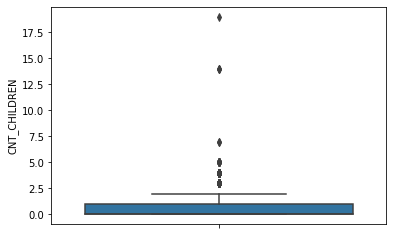

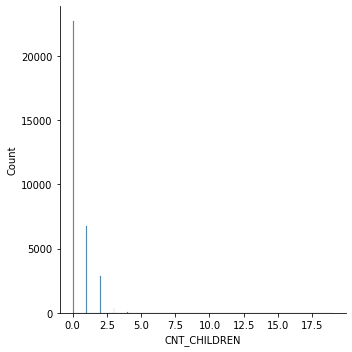

AMT_INCOME_TOTAL


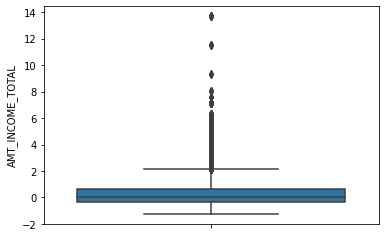

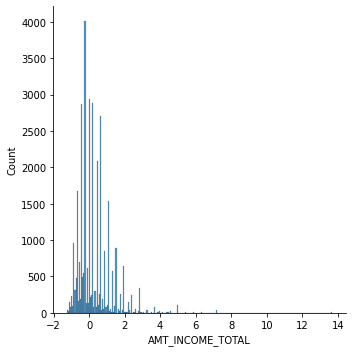

DAYS_BIRTH


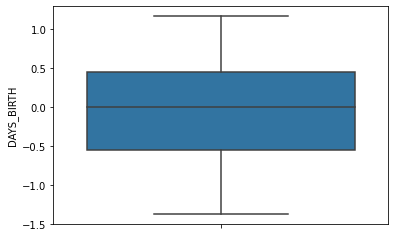

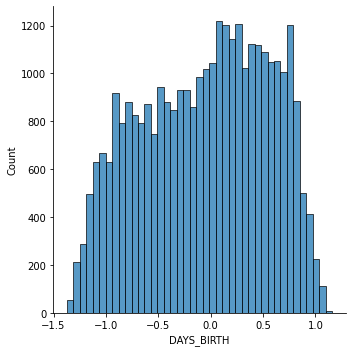

DAYS_EMPLOYED


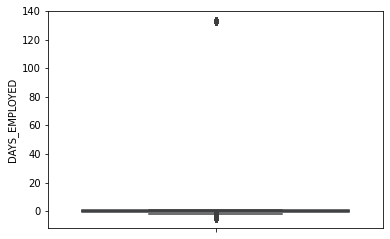

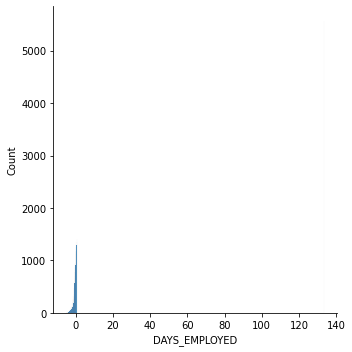

FLAG_WORK_PHONE


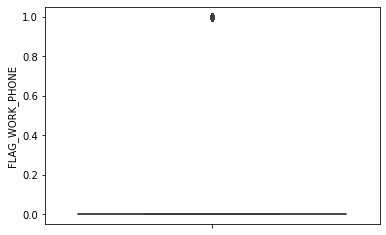

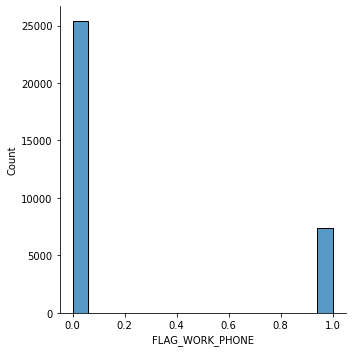

FLAG_PHONE


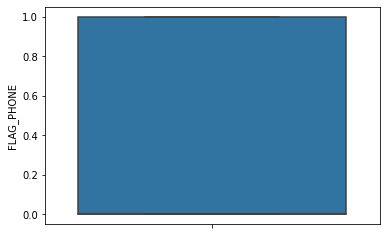

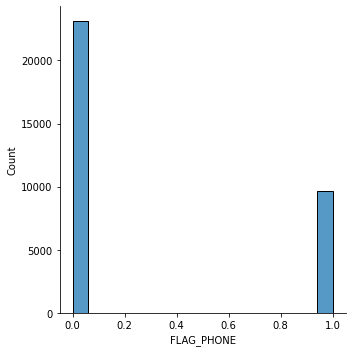

FLAG_EMAIL


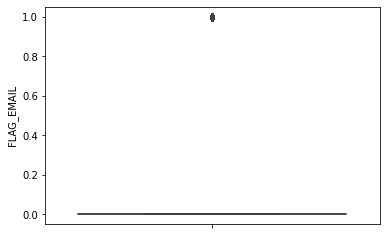

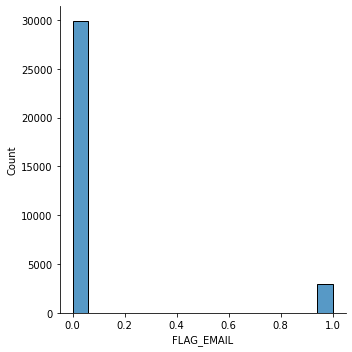

CNT_FAM_MEMBERS


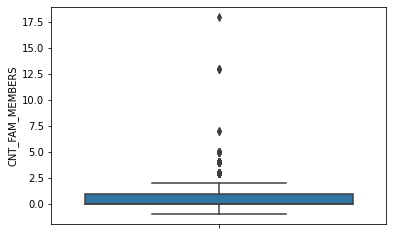

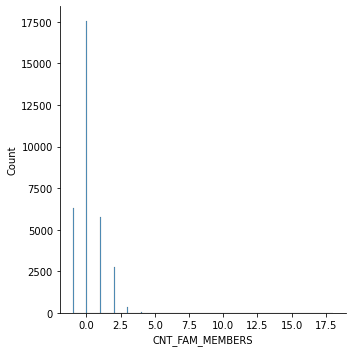

CODE_GENDER_F


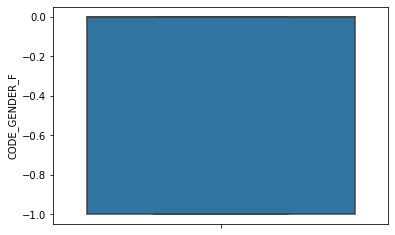

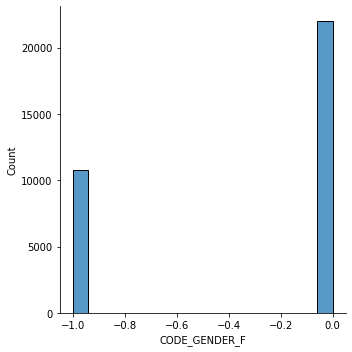

CODE_GENDER_M


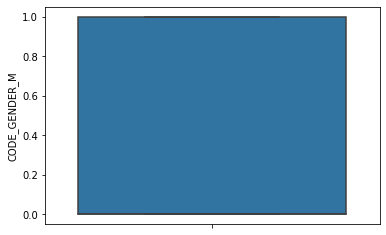

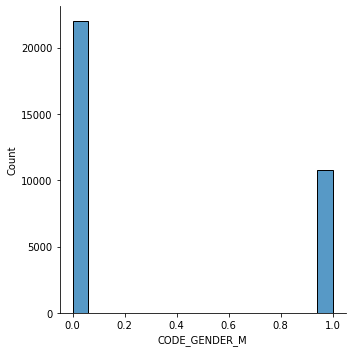

FLAG_OWN_CAR_N


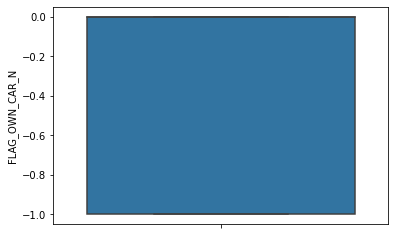

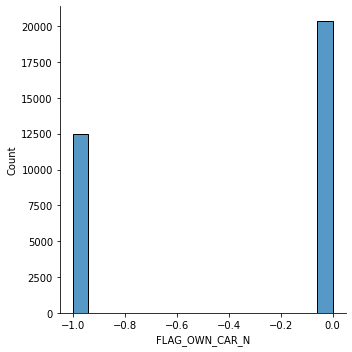

FLAG_OWN_CAR_Y


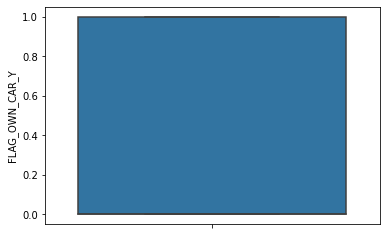

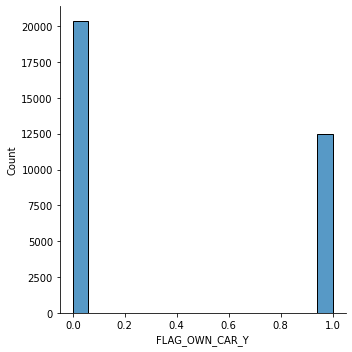

FLAG_OWN_REALTY_N


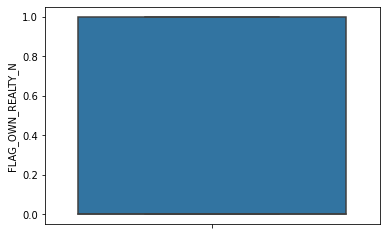

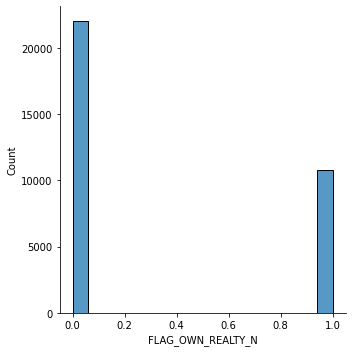

FLAG_OWN_REALTY_Y


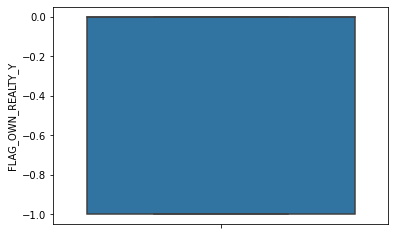

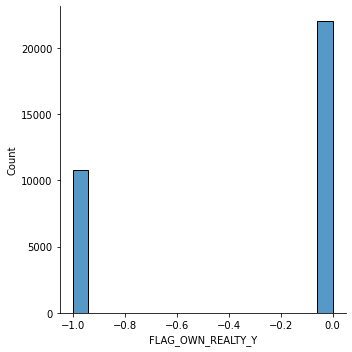

NAME_INCOME_TYPE_Commercial associate


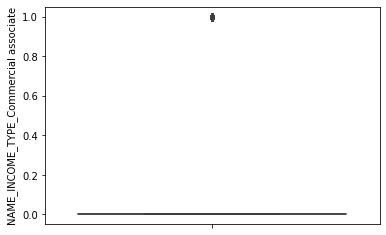

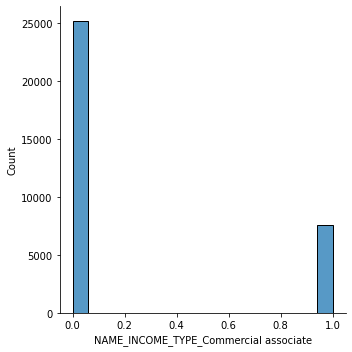

NAME_INCOME_TYPE_Pensioner


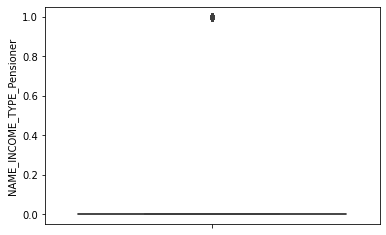

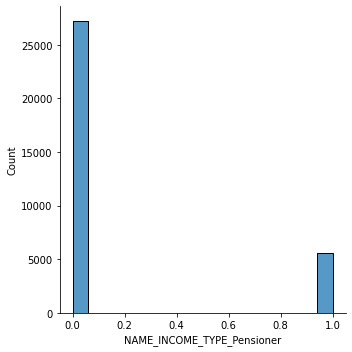

NAME_INCOME_TYPE_State servant


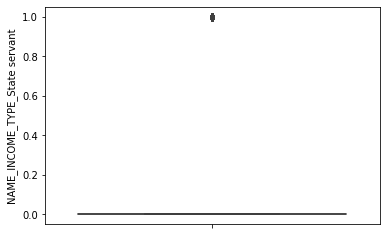

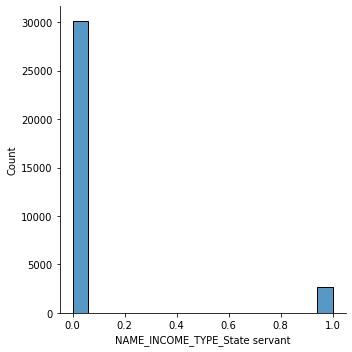

NAME_INCOME_TYPE_Student


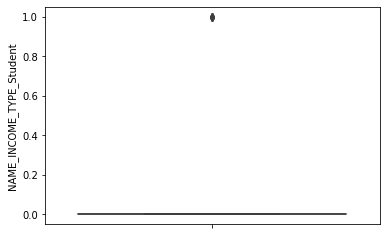

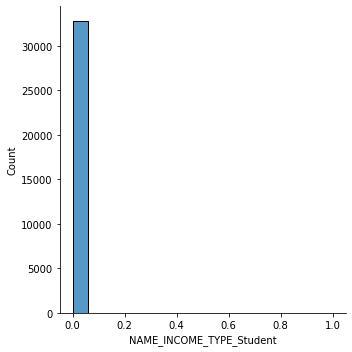

NAME_INCOME_TYPE_Working


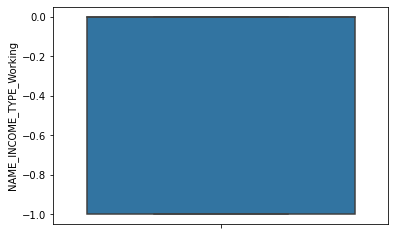

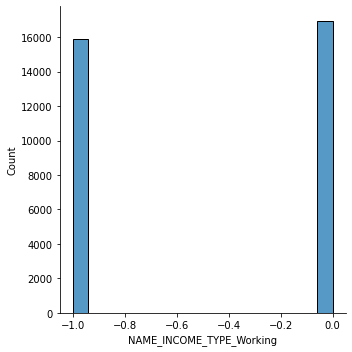

NAME_EDUCATION_TYPE_Academic degree


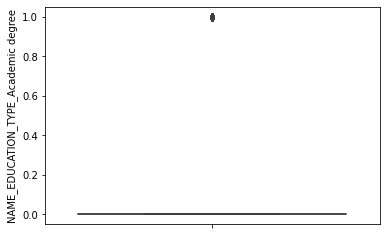

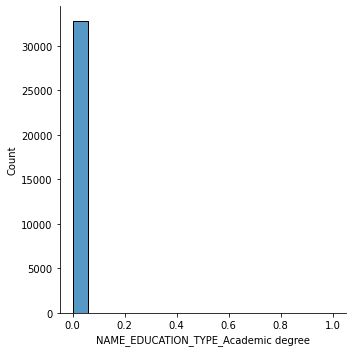

NAME_EDUCATION_TYPE_Higher education


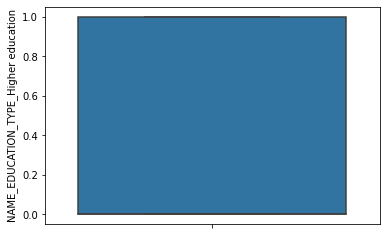

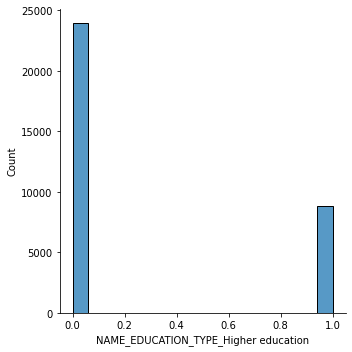

NAME_EDUCATION_TYPE_Incomplete higher


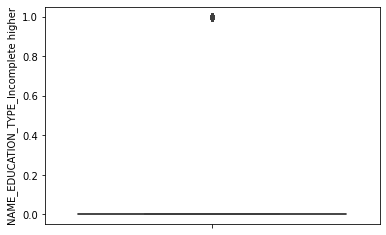

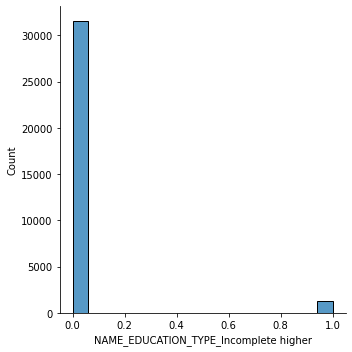

NAME_EDUCATION_TYPE_Lower secondary


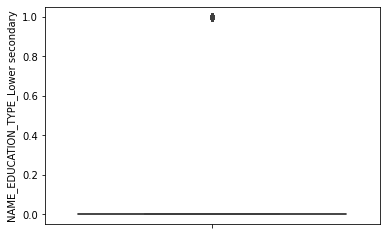

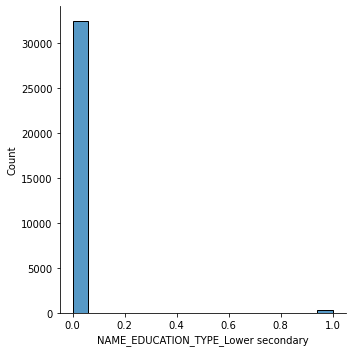

NAME_EDUCATION_TYPE_Secondary / secondary special


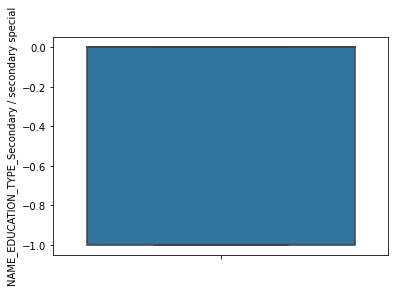

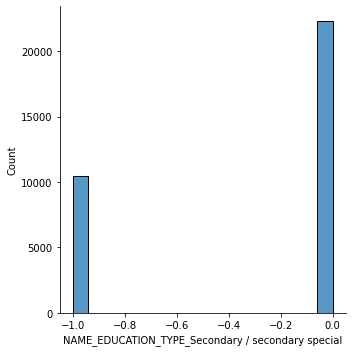

NAME_FAMILY_STATUS_Civil marriage


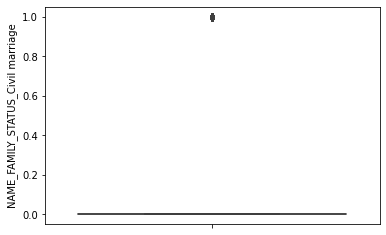

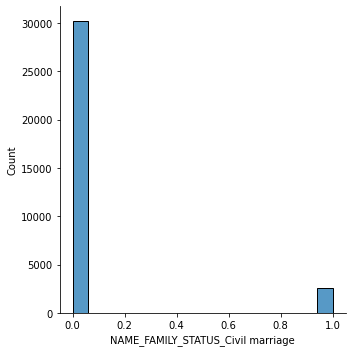

NAME_FAMILY_STATUS_Married


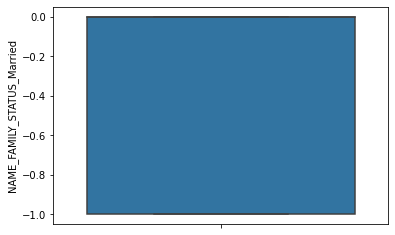

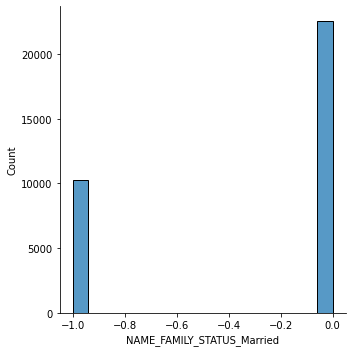

NAME_FAMILY_STATUS_Separated


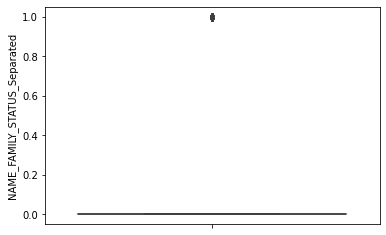

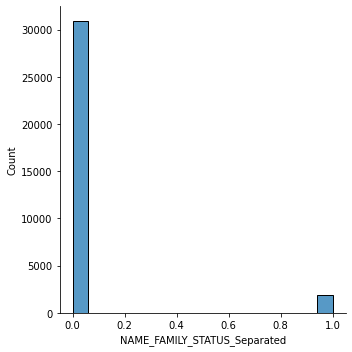

NAME_FAMILY_STATUS_Single / not married


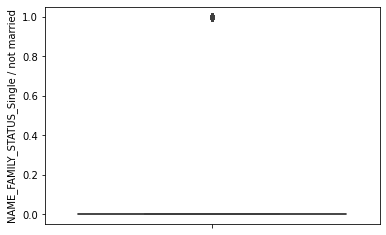

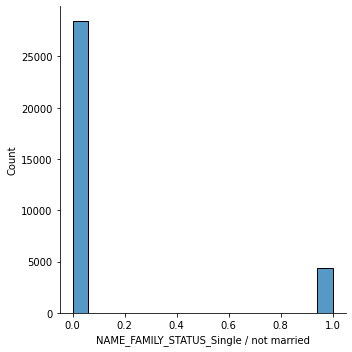

NAME_FAMILY_STATUS_Widow


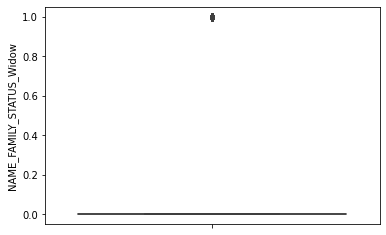

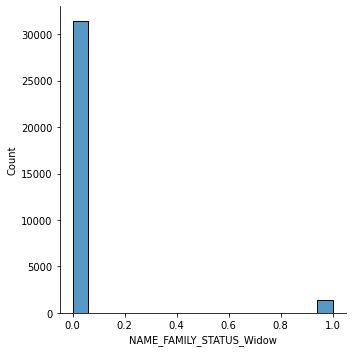

NAME_HOUSING_TYPE_Co-op apartment


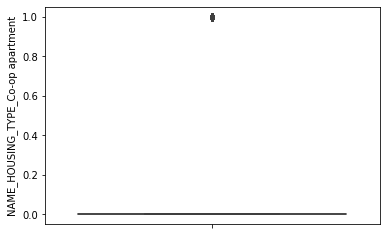

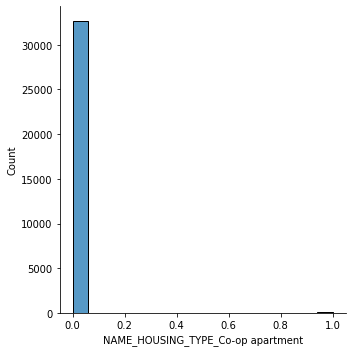

NAME_HOUSING_TYPE_House / apartment


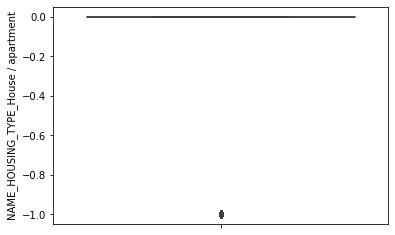

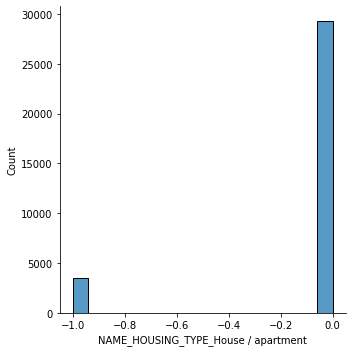

NAME_HOUSING_TYPE_Municipal apartment


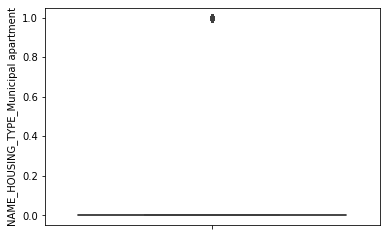

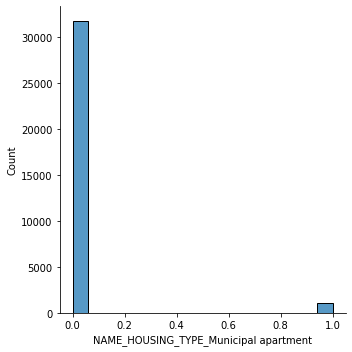

NAME_HOUSING_TYPE_Office apartment


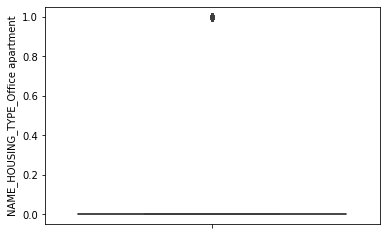

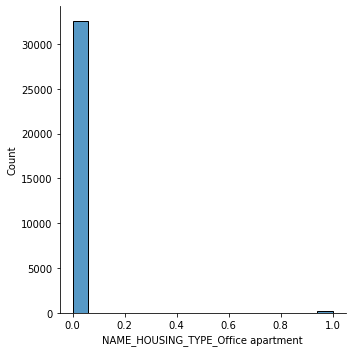

NAME_HOUSING_TYPE_Rented apartment


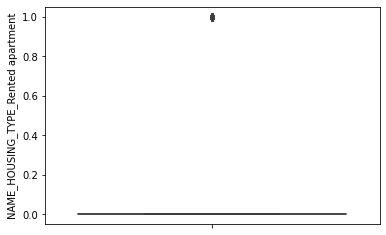

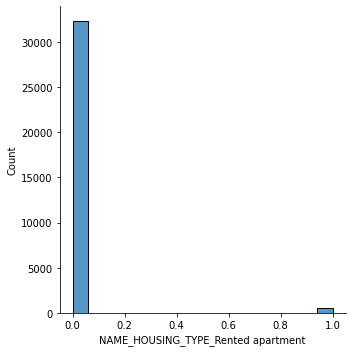

NAME_HOUSING_TYPE_With parents


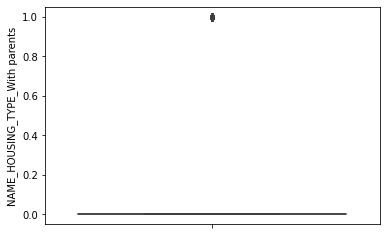

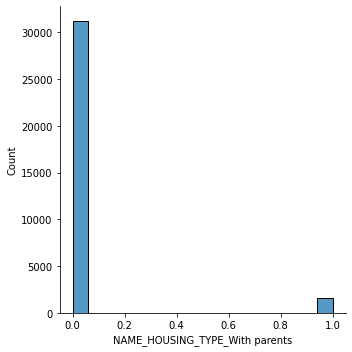

In [38]:
# Plot disctribution graphs for all numerical features
for feature in X_scaled.columns:
    if X_scaled[feature].dtype != "object" and feature != "ID":
        print(feature)
        sns.boxplot(data=X_scaled,y=feature)
        plt.show()
        sns.displot(data=X_scaled,x=feature)
        plt.show()

Since there are significantly more records for good customers it is important to use an strategy to account for this. I use the SMOTE technique for this purpose, which creates syntethic values that preserve the feature distributions and balance the number of observations for the two classes.

In [39]:
# using SMOTE algorithm
oversample = SMOTE()
X_balanced, y_balanced = oversample.fit_resample(X_scaled, y_train)

In [40]:
y_balanced.value_counts(normalize=True)

0    0.5
1    0.5
Name: DEFAULT, dtype: float64

As seen above the newly created balanced training dataset contains the same amount of good and bad records. Looking at the shape of the labels vector it is possible to see that there are more data points than there were initially, which is caused by the creation of syntethic data through the SMOTE algorithm

In [41]:
y_balanced.shape

(64502,)

## Logistic Regression

In [42]:
# Instaniate Logistic Regression classifier
lr_classifier = LogisticRegression()

In [43]:
lr_classifier.fit(X_balanced,y_balanced)
lr_classifier.score(X_balanced,y_balanced),lr_classifier.score(X_test_scaled,y_test)

(0.5738271681498248, 0.6338453099286889)

### Evaluation

Training dataset

In [44]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], label="precision")
    plt.plot(thresholds, recalls[:-1], label="recall")
    plt.xlabel("Threshold")
    plt.ylabel("Metric")
    plt.legend(loc="upper right")
    plt.show()
    plt.plot(recalls,precisions)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

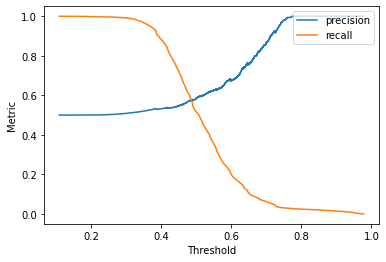

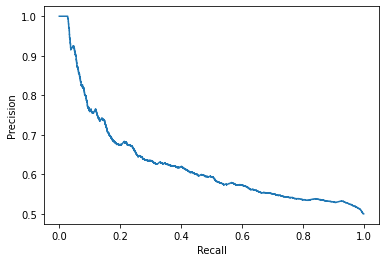

In [45]:
precisions, recalls, thresholds = precision_recall_curve(y_balanced,lr_classifier.predict_proba(X_balanced)[:,1])
plot_precision_recall(precisions, recalls, thresholds)

In [46]:
target_names = ['good', 'bad']
print(classification_report(y_balanced,lr_classifier.predict(X_balanced), target_names=target_names))

              precision    recall  f1-score   support

        good       0.57      0.63      0.60     32251
         bad       0.58      0.51      0.55     32251

    accuracy                           0.57     64502
   macro avg       0.57      0.57      0.57     64502
weighted avg       0.57      0.57      0.57     64502



Test dataset

In [47]:
target_names = ['good', 'bad']
print(classification_report(y_test,lr_classifier.predict(X_test_scaled), target_names=target_names))

              precision    recall  f1-score   support

        good       0.99      0.64      0.77      3590
         bad       0.02      0.46      0.04        56

    accuracy                           0.63      3646
   macro avg       0.50      0.55      0.41      3646
weighted avg       0.97      0.63      0.76      3646



## Logistic Regression (statsmodels)

In this case, it is necessary to use the features without the dummy transformation so that it is easier to define the model

In [48]:
df_aux = df_application.merge(df_defaults,how="inner",on="ID")
# Include all the features except for the labels and IDs
X_aux = df_aux.iloc[:,1:-1] 
# Include all the labels
y_aux = df_aux.iloc[:,-1] 
# Split the data into training (90%) and test (10%) datasets 
X_aux_train, X_aux_test, y_aux_train, y_aux_test = train_test_split(X_aux, y_aux, test_size=0.1, random_state=1)

# building the model and fitting the data
logit = smf.logit("DEFAULT ~ C(CODE_GENDER) + C(FLAG_OWN_CAR) + C(FLAG_OWN_REALTY) + CNT_CHILDREN + AMT_INCOME_TOTAL + C(NAME_INCOME_TYPE) + C(NAME_EDUCATION_TYPE) + C(NAME_FAMILY_STATUS) + C(NAME_HOUSING_TYPE) + DAYS_BIRTH + DAYS_EMPLOYED + C(FLAG_WORK_PHONE) + C(FLAG_PHONE) + C(FLAG_EMAIL) + CNT_FAM_MEMBERS", data=X_aux_train.join(y_aux_train)).fit()
# logit = smf.logit("DEFAULT ~ C(CODE_GENDER) + C(FLAG_OWN_CAR) + C(FLAG_OWN_REALTY) + CNT_CHILDREN + AMT_INCOME_TOTAL + C(NAME_EDUCATION_TYPE) + C(NAME_FAMILY_STATUS) + C(NAME_HOUSING_TYPE) + DAYS_BIRTH + DAYS_EMPLOYED + C(FLAG_WORK_PHONE) + C(FLAG_PHONE) + C(FLAG_EMAIL) + CNT_FAM_MEMBERS", data=X_aux_train.join(y_aux_train)).fit()
# logit = smf.logit("DEFAULT ~ C(CODE_GENDER) + C(FLAG_OWN_CAR) + C(FLAG_OWN_REALTY) + CNT_CHILDREN + AMT_INCOME_TOTAL + C(NAME_EDUCATION_TYPE) + C(NAME_FAMILY_STATUS) + DAYS_BIRTH + DAYS_EMPLOYED + C(FLAG_EMAIL) + CNT_FAM_MEMBERS", data=X_aux_train.join(y_aux_train)).fit()

         Current function value: 0.082372
         Iterations: 35


In [49]:
print(logit.summary())

                           Logit Regression Results                           
Dep. Variable:                DEFAULT   No. Observations:                32811
Model:                          Logit   Df Residuals:                    32782
Method:                           MLE   Df Model:                           28
Date:                Mon, 05 Jul 2021   Pseudo R-squ.:                 0.04657
Time:                        13:27:35   Log-Likelihood:                -2702.7
converged:                      False   LL-Null:                       -2834.7
Covariance Type:            nonrobust   LLR p-value:                 3.061e-40
                                                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                 -23.9015    753.343     -0.032      0.975   -1500.426    1452.

In [50]:
target_names = ['good', 'bad']
print(classification_report(y_aux_test,logit.predict(X_aux_test)\
                            .apply(lambda x: 0 if x < 0.5 else 1), target_names=target_names))

              precision    recall  f1-score   support

        good       0.98      1.00      0.99      3590
         bad       0.00      0.00      0.00        56

    accuracy                           0.98      3646
   macro avg       0.49      0.50      0.50      3646
weighted avg       0.97      0.98      0.98      3646



## XGBoost

In [51]:
# Instantiate XGBoost classifier
xgb_classifier = XGBClassifier()

In [52]:
xgb_classifier.fit(X_balanced,y_balanced)
xgb_classifier.score(X_balanced,y_balanced),xgb_classifier.score(X_test_scaled,y_test)

[13:27:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(0.9903258813680196, 0.9769610532089962)

In [53]:
target_names = ['good', 'bad']
print(classification_report(y_balanced,xgb_classifier.predict(X_balanced), target_names=target_names))

              precision    recall  f1-score   support

        good       0.99      0.99      0.99     32251
         bad       0.99      0.99      0.99     32251

    accuracy                           0.99     64502
   macro avg       0.99      0.99      0.99     64502
weighted avg       0.99      0.99      0.99     64502



In [54]:
target_names = ['good', 'bad']
print(classification_report(y_test,xgb_classifier.predict(X_test_scaled), target_names=target_names))

              precision    recall  f1-score   support

        good       0.99      0.99      0.99      3590
         bad       0.22      0.20      0.21        56

    accuracy                           0.98      3646
   macro avg       0.60      0.59      0.60      3646
weighted avg       0.98      0.98      0.98      3646



In [55]:
parameters = {
    'eta': [0.05, 0.1],
    'max_depth': [6, 9],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
    'objective': ['binary:logistic'],
}

clf = GridSearchCV(xgb_classifier, parameters, n_jobs=1,cv=2)
    
clf.fit(X_balanced,y_balanced)

print(f"The best parameters found are: {clf.best_params_}")

[13:27:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:27:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:27:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:27:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

# <font color="purple">Model evaluation</font>

In [56]:
clf.score(X_balanced,y_balanced),clf.score(X_test_scaled,y_test)

(0.9927599144212582, 0.9777838727372463)

In [57]:
target_names = ['good', 'bad']
print(classification_report(y_test,clf.predict(X_test_scaled), target_names=target_names))

              precision    recall  f1-score   support

        good       0.99      0.99      0.99      3590
         bad       0.23      0.20      0.21        56

    accuracy                           0.98      3646
   macro avg       0.61      0.59      0.60      3646
weighted avg       0.98      0.98      0.98      3646



# <font color="purple">Model deployment</font>

In [58]:
file_name = "model.pkl"
# save model
pickle.dump(xgb_classifier, open(file_name, "wb"))